In [1]:
import numpy as np
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy.optimize
import pandas as pd
from IPython.display import Audio
import csv

In [2]:
def nextpow2(N):
    n = 1
    while n < N:
        n *= 2
    return n

In [3]:
def F_getF0FromSpectre(
    fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz, plot=False
):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude
        - H: number of times the spectrum is decimated
        - fmin_hz: minimum frequency in Hz to look for F0
        - fmax_hz: maximum frequency in Hz to look for F0
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - spFreq_hz_v: vector containing the SpectralProduct frequencies in Hz
        - spAmpl_v: vector containing the SpectralProduct amplitudes
        - f0_hz: estimated F0 in Hz
    """
    R = int(Nfft / (2 * H) + 1)
    P = np.zeros(R)
    h = np.atleast_2d(np.arange(1, H + 1)).T
    f_k = np.arange(1, R + 1)
    A = np.abs(fftAmpl_v[h * f_k])
    P = np.prod(A, axis=0)
    F = np.linspace(0, sr_hz / (2 * H), R)

    spAmpl_v = P
    spFreq_hz_v = F

    n_min = int(fmin_hz / sr_hz * Nfft)
    n_max = int(fmax_hz / sr_hz * Nfft)
    assert n_max < R, "f_max est trop grand !"

    f0_hz = F[n_min:n_max][np.argmax(spAmpl_v[n_min:n_max])]

    return spFreq_hz_v, spAmpl_v, f0_hz

In [4]:
def refine_peak(freqs, mag, f, alpha=0.1):
    f_min = (1 - alpha) * f
    f_max = (1 + alpha) * f

    n_min = np.searchsorted(freqs, f_min, side="left")
    n_max = np.searchsorted(freqs, f_max, side="right")
    assert n_min != 0
    assert n_min != len(freqs)
    assert n_max != 0
    assert n_max != len(freqs)

    i_harmo = np.argmax(mag[n_min:n_max])

    return i_harmo + n_min

In [5]:
# note <-> fréquence
def freq_to_midi(freq: float):
    note_number_f = 12 * math.log2(freq / 440) + 49
    note_number = round(note_number_f)
    delta = note_number_f - note_number
    return note_number, delta


def midi_to_name(midi: int):
    notes = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
    note = (midi - 1) % len(notes)
    note = notes[note]
    octave = (midi + 8) // len(notes)

    return note + str(octave)

In [6]:
def get_envelope(t, x, d=1):
    def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
        """
        Input :
        s: 1d-array, data signal from which to extract high and low envelopes
        dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
        split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
        Output :
        lmin,lmax : high/low envelope idx of input signal s
        """

        # locals min
        lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
        # locals max
        lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1

        if split:
            # s_mid is zero if s centered around x-axis or more generally mean of signal
            s_mid = np.mean(s)
            # pre-sorting of locals min based on relative position with respect to s_mid
            lmin = lmin[s[lmin] < s_mid]
            # pre-sorting of local max based on relative position with respect to s_mid
            lmax = lmax[s[lmax] > s_mid]

        # global min of dmin-chunks of locals min
        lmin = lmin[
            [i + np.argmin(s[lmin[i : i + dmin]]) for i in range(0, len(lmin), dmin)]
        ]
        # global max of dmax-chunks of locals max
        lmax = lmax[
            [i + np.argmax(s[lmax[i : i + dmax]]) for i in range(0, len(lmax), dmax)]
        ]

        return lmin, lmax

    _, lmax = hl_envelopes_idx(x, dmax=d)
    lmax = np.interp(t, t[lmax], x[lmax])
    return lmax

In [7]:
def traiter(filename, harmos, titre):
    plt.ioff()
    window = np.hamming

    fs, sig = scipy.io.wavfile.read(filename)
    sig = sig.astype(np.float32)
    sig /= np.max(abs(sig))

    t = np.arange(len(sig)) / fs

    env = get_envelope(t, sig, 100)

    plt.figure(figsize=(15, 3))
    plt.plot(t, sig)
    plt.plot(t, env)
    plt.savefig(filename + ".env.png")

    ##### CUTTING

    MARGE_START_BEFORE = int(0.01 * fs)
    MARGE_START_AFTER = int(0.1 * fs)
    MARGE_SEARCH_END = int(0.2 * fs)
    MARGE_SILENCE = 0.01

    i_silence = np.argmax(abs(sig)) - MARGE_START_BEFORE
    print(f"le signal commence à {i_silence/fs} s")
    silence_level = np.max(abs(sig[:i_silence]))
    print(
        f"niveau de silence: {20*np.log10(silence_level):.2f} dB ({silence_level:.2f} V)"
    )

    i_start = i_silence + MARGE_START_AFTER

    i_searchend = i_start + MARGE_SEARCH_END
    i_end = i_searchend + np.argmax(env[i_searchend:] < silence_level + MARGE_SILENCE)
    print("le signal finit à", i_end / fs)

    # zoom = 0.01
    # plt.figure(figsize=(15, 5))
    # plt.title(f"bruit de fond: {20*np.log10(silence_level):.2f} dB")
    # plt.subplot(1, 3, 1)
    # plt.plot(t, abs(sig))
    # plt.plot(t, env)
    # plt.hlines(silence_level, t[0], t[-1], "red")
    # plt.vlines(t[i_silence], 0, 1, "red")
    # plt.xlim(t[i_silence] - zoom, t[i_silence] + zoom)
    # plt.subplot(1, 3, 2)
    # plt.plot(t, abs(sig))
    # plt.plot(t, env)
    # plt.hlines(silence_level, t[0], t[-1], "red")
    # plt.vlines(t[i_start], 0, 1, "red")
    # plt.xlim(t[i_start] - zoom, t[i_start] + zoom)
    # plt.subplot(1, 3, 3)
    # plt.plot(t, abs(sig))
    # plt.plot(t, env)
    # plt.hlines(silence_level, t[0], t[-1], "red")
    # plt.vlines(t[i_end], 0, 1, "red")
    # plt.xlim(t[i_end] - zoom, t[i_end] + zoom)
    # plt.savefig(filename + ".decoupe.png")

    sig_cut = sig[i_start:i_end]
    t_cut = t[i_start:i_end]
    # plt.figure(figsize=(15, 3))
    # plt.plot(t_cut, sig_cut)
    # plt.savefig(filename + ".statio.png")

    # spectre
    Nfft = 8 * nextpow2(sig_cut.shape[0])
    freqs = np.fft.rfftfreq(Nfft, 1 / fs)
    fft = np.fft.rfft(sig_cut * window(len(sig_cut)), Nfft) / len(sig_cut)
    mag = abs(fft)

    # align harmos with fft bins
    harmos = np.array(harmos)
    harmos_ratio = np.zeros_like(harmos, dtype=np.float32)
    harmos_idx = np.zeros_like(harmos, dtype=np.int64)
    harmos_amp = np.zeros_like(harmos, dtype=np.float32)
    for n, f in enumerate(harmos):
        i = refine_peak(freqs, mag, f, 0.01)
        harmos_idx[n] = i
        harmos[n] = freqs[i]
        harmos_ratio[n] = freqs[i] / harmos[0]
        harmos_amp[n] = 20 * np.log10(mag[i])

    midi, delta = freq_to_midi(harmos[0])
    print(f"{harmos[0]:.2f} Hz, (={midi_to_name(midi)}{delta:+.2f} Hz)")

    plt.figure(figsize=(15, 3))
    plt.xlim(min(harmos) - 200, max(harmos) + 200)
    plt.plot(freqs, 20 * np.log10(mag))
    for f in harmos:
        plt.axvline(f, linestyle="--", color="red", alpha=0.6)
    plt.savefig(filename + ".spectre.png")

    table = pd.DataFrame(
        np.c_[harmos, harmos_ratio],
        columns=["Fréquence (Hz)", "Ratio d'harmonicité"],
    )
    table.to_latex(
        filename + ".partiels.tex",
        index=True,
        float_format="%.2f",
        caption=f"Partiels de {titre}",
        label=f"table:partiels-{filename}",
    )
    # display(pd.DataFrame(np.c_[harmos, rapport_harmo], columns=["Fréquence", "Rapport harmonique"]))

    ####
    # plt.figure(figsize=(15, 3*len(harmos)))
    # plt.suptitle("Analyse des partiels de " + titre)
    # for i, f in enumerate(harmos):
    #     plt.subplot(len(harmos), 1, i+1)
    #     delta = 1
    #     window = np.where(np.logical_and(freqs > f-delta, freqs < f+delta), 1, 0)
    #     filt = scipy.signal.butter(
    #         2, (f/delta, f*delta), btype="bandpass", fs=fs, output="sos"
    #     )
    #     plt.loglog(*scipy.signal.sosfreqz(filt,fs=fs))
    #     plt.show()
    #     sig_filtered = scipy.signal.sosfilt(filt, sig_cut)
    #     env_filtered = get_envelope(t_cut, sig_filtered, 5)
    #     plt.title(f"Partiel $f_{i}={f:.1f} Hz = {f/harmos[0]:.1f} f_0$")
    #     plt.plot(t_cut, sig_filtered, label="partiel filtré")
    #     plt.plot(t_cut, env_filtered, label="enveloppe")

    #     def exp_decay(x, A, alpha):
    #         return A * np.exp(-alpha * x)
    #     try:
    #         popt, pcov = scipy.optimize.curve_fit(exp_decay, t_cut, env_filtered)
    #         perr = np.sqrt(np.diag(pcov))
    #         print(f, popt, perr)
    #         plt.plot(t_cut, exp_decay(t_cut, *popt), label="enveloppe fittée")
    #     except RuntimeError:
    #         print(f"pas pu fitter pour le f_{i}")
    #     # display(Audio(sig_filtered, rate=fs))
    # plt.legend()
    # plt.savefig(filename+".partiels.png")
    plt.ion()

/tmp/ipykernel_17600/4096297392.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = scipy.io.wavfile.read(filename)


le signal commence à 1.5698541666666668 s
niveau de silence: -52.77 dB (0.00 V)
le signal finit à 2.1426666666666665
703.86 Hz, (=F5+0.13 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(
/tmp/ipykernel_17600/4096297392.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = scipy.io.wavfile.read(filename)


le signal commence à 2.3575208333333335 s
niveau de silence: -48.31 dB (0.00 V)
le signal finit à 3.4780208333333333
1410.64 Hz, (=F6+0.17 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(
/tmp/ipykernel_17600/4096297392.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = scipy.io.wavfile.read(filename)


le signal commence à 2.4601041666666665 s
niveau de silence: -51.10 dB (0.00 V)
le signal finit à 3.060791666666667
2835.94 Hz, (=F7+0.26 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.10345833333333333 s
niveau de silence: -34.31 dB (0.02 V)
le signal finit à 7.2730625
173.69 Hz, (=F3-0.09 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.0655 s
niveau de silence: -31.10 dB (0.03 V)
le signal finit à 14.934291666666667
442.01 Hz, (=A4+0.08 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.1125 s
niveau de silence: -32.04 dB (0.03 V)
le signal finit à 13.2305
442.01 Hz, (=A4+0.08 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.07004166666666667 s
niveau de silence: -36.94 dB (0.01 V)
le signal finit à 10.177604166666667
1324.00 Hz, (=E6+0.07 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.083625 s
niveau de silence: -38.40 dB (0.01 V)
le signal finit à 1.3696041666666667
124.05 Hz, (=B2+0.08 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.1400625 s
niveau de silence: -1.89 dB (0.80 V)
le signal finit à 0.4400625
125.98 Hz, (=B2+0.35 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.11620833333333333 s
niveau de silence: -50.45 dB (0.00 V)
le signal finit à 1.4717708333333333
123.87 Hz, (=B2+0.06 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.08839583333333334 s
niveau de silence: -55.73 dB (0.00 V)
le signal finit à 0.5125416666666667
125.98 Hz, (=B2+0.35 Hz)


/tmp/ipykernel_17600/4096297392.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(


le signal commence à 0.047875 s
niveau de silence: -10.00 dB (0.32 V)
le signal finit à 0.347875


IndexError: index 0 is out of bounds for axis 0 with size 0

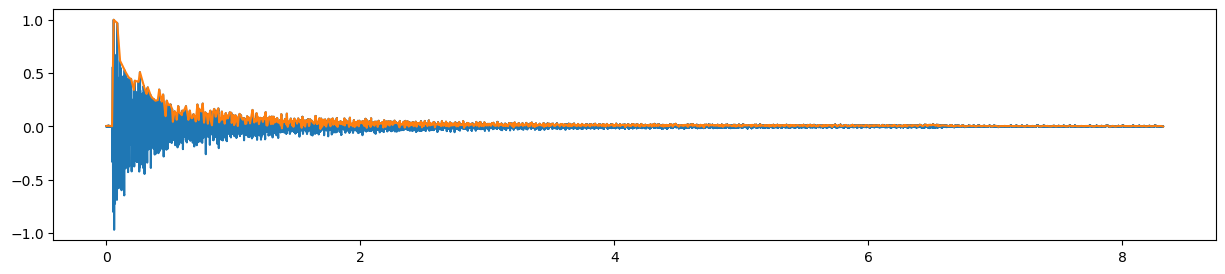

In [8]:
from tqdm import tqdm

for csv in [
    "harmoniques_glock.csv",
    "harmoniques_vibra.csv",
    "harmoniques_timbale.csv",
]:
    files = pd.read_csv(csv)
    for _, file in files.iterrows():
        filename = file["filename"]
        titre = file["titre"]
        titre = filename.split(".")[0] if pd.isna(titre) else titre
        harmos = [file[k] for k in file.keys()[2:] if not pd.isna(file[k])]
        harmos = sorted(harmos)
        traiter(filename, harmos, titre)
        plt.close("all")